In [1]:
# Refer: https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b

## Importing libraries

In [9]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from category_encoders import hashing as hs
import itertools

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format
import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score, recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

# CTU - 13: Feature Engineering

In [2]:
# Loading data from disk
train = pd.read_csv('./train_alldata_EDA.csv')


In [3]:
test = pd.read_csv('./test_alldata_EDA.csv')

In [4]:
# Utility function
def multi_corr(col1, col2="target", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" after applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [5]:
def corr(col1, col2="target", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

In [10]:
def convertToOneClass(y):
    if y == 1:
        return -1
    return 1

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



## Removing unnecessary features

In [8]:
train.drop(columns='Unnamed: 0', axis=1, inplace=True)
test.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [9]:
train.shape, test.shape

((9950992, 16), (4271468, 16))

In [10]:
train

,starttime,dur,proto,srcaddr,sport,dir,dstaddr,dport,state,stos,dtos,totpkts,totbytes,srcbytes,label,target
0,2011-08-12 22:08:41.277072,0.000000,tcp,74.86.42.203,80,->,147.32.86.50,3072,SA_,0.0,0.0,1,60,60,flow=Background-TCP-Established,0
1,2011-08-14 23:11:07.462572,0.003940,udp,67.49.33.55,53622,<->,147.32.84.229,13363,CON,0.0,0.0,4,2995,60,flow=Background-UDP-Established,0
2,2011-08-15 14:02:41.946307,0.000289,udp,147.32.86.171,56559,<->,147.32.80.9,53,CON,0.0,0.0,2,392,77,flow=To-Background-UDP-CVUT-DNS-Server,0
3,2011-08-16 08:46:24.544795,1336.481934,udp,77.87.33.112,35057,<->,147.32.84.229,13363,CON,0.0,0.0,4,1138,150,flow=Background-UDP-Established,0
4,2011-08-18 10:41:28.980563,0.984197,tcp,84.122.159.122,1958,->,147.32.84.118,6881,S_RA,0.0,0.0,6,366,186,flow=Background-TCP-Attempt,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950987,2011-08-15 01:55:47.339228,0.000598,udp,74.65.181.205,42064,<->,147.32.84.229,13363,CON,0.0,0.0,2,552,75,flow=Background-UDP-Established,0
9950988,2011-08-16 04:08:02.954859,0.000469,udp,147.32.86.20,53758,<->,147.32.80.9,53,CON,0.0,0.0,2,239,79,flow=To-Background-UDP-CVUT-DNS-Server,0
9950989,2011-08-12 23:48:40.386105,0.000147,tcp,157.55.185.43,61000,->,147.32.85.100,41598,S_RA,0.0,0.0,2,126,66,flow=Background-TCP-Attempt,0
9950990,2011-08-17 13:07:44.185185,0.000253,udp,147.32.84.138,40794,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0


Refer: https://www.elastic.co/guide/en/ecs/master/ecs-network.html
* Network bytes: Total bytes trasferred by the network. It is sum of 'sbytes' (Source to destination bytes) and 'dbytes' (Destination to source bytes).

In [11]:
saved_dict = {}

In [12]:
train.columns

Index(['starttime', 'dur', 'proto', 'srcaddr', 'sport', 'dir', 'dstaddr',
       'dport', 'state', 'stos', 'dtos', 'totpkts', 'totbytes', 'srcbytes',
       'label', 'target'],
      dtype='object')

In [13]:
starttime = train['starttime']
srcaddr = train['srcaddr']
dstaddr = train['dstaddr']
state = train['state']

In [14]:
# Dropping columns which are not useful for the classification
# label is for binary classification
# all the other columns are address related and not present in sample train data
train.drop(['starttime', 'srcaddr', 'dstaddr', 'state'], axis=1, inplace=True)

In [15]:
# To use during test data transformation
saved_dict['to_drop'] = ['starttime', 'srcaddr', 'dstaddr', 'state']

In [16]:
train.shape, test.shape

((9950992, 12), (4271468, 16))

In [17]:
# mode values of every features, will use to fill Null values of test
mode_dict = train.mode().iloc[0].to_dict()

In [18]:
mode_dict

{'dur': 0.0,
 'proto': 'udp',
 'sport': '13363',
 'dir': '  <->',
 'dport': '53',
 'stos': 0.0,
 'dtos': 0.0,
 'totpkts': 2,
 'totbytes': 214,
 'srcbytes': 81,
 'label': 'flow=To-Background-UDP-CVUT-DNS-Server',
 'target': 0}

In [19]:
saved_dict['moded_featute'] = mode_dict

In [20]:
saved_dict

{'to_drop': ['starttime', 'srcaddr', 'dstaddr', 'state'],
 'moded_featute': {'dur': 0.0,
  'proto': 'udp',
  'sport': '13363',
  'dir': '  <->',
  'dport': '53',
  'stos': 0.0,
  'dtos': 0.0,
  'totpkts': 2,
  'totbytes': 214,
  'srcbytes': 81,
  'label': 'flow=To-Background-UDP-CVUT-DNS-Server',
  'target': 0}}

In [21]:
# creating x and y set from the dataset
x_train, y_train, y_train_label = train.drop(columns=['label', 'target']), train['target'], train['label']
# x_test, y_test, y_test_label = test.drop(columns=['label', 'target']), test['target'], test['label']

In [22]:
print(x_train.shape, y_train.shape, y_train_label.shape)
print()
# print(x_test.shape, y_test.shape, y_test_label.shape)

(9950992, 10) (9950992,) (9950992,)



In [23]:
# Saving all the files to disk to use later
pickle.dump((x_train, y_train, y_train_label), open('./final_train.pkl', 'wb'))
# pickle.dump((x_test, y_test, y_test_label), open('./final_test.pkl', 'wb'))

In [24]:
# getting categorical and numerical columns in 2 diff lists
num_col = [ 'dur', 'sport', 'dport', 'totpkts', 'totbytes', 'srcbytes']
cat_col = list(set(x_train.columns) - set(num_col))

In [25]:
# To use later, during test data cleaning
saved_dict['cat_col'] = cat_col
saved_dict['num_col'] = num_col

In [26]:
saved_dict

{'to_drop': ['starttime', 'srcaddr', 'dstaddr', 'state'],
 'moded_featute': {'dur': 0.0,
  'proto': 'udp',
  'sport': '13363',
  'dir': '  <->',
  'dport': '53',
  'stos': 0.0,
  'dtos': 0.0,
  'totpkts': 2,
  'totbytes': 214,
  'srcbytes': 81,
  'label': 'flow=To-Background-UDP-CVUT-DNS-Server',
  'target': 0},
 'cat_col': ['proto', 'dtos', 'dir', 'stos'],
 'num_col': ['dur', 'sport', 'dport', 'totpkts', 'totbytes', 'srcbytes']}

In [27]:
def is_hex(s):
    try:
        int(s, 16)
        return True
    except ValueError:
        return False

def convertHexInSport(port):
    if str(int(port, 16)) != port:
        return int(port, 16)

    return int(port)




In [28]:
x_train['sport'] = x_train['sport'].apply(convertHexInSport)
x_train['dport'] = x_train['dport'].apply(convertHexInSport)

## Standardizing
    
As we have seen that the range of few features in this dataset is very large. So we will keep everything within certain range by applying standardscaler. After this all the features will have mean 0 and std 1

In [29]:
# Standardizing the data
scaler = MinMaxScaler()
scaler = scaler.fit(x_train[num_col])

In [30]:
x_train[num_col] = scaler.transform(x_train[num_col])

In [31]:
x_train.head()

,dur,proto,sport,dir,dport,stos,dtos,totpkts,totbytes,srcbytes
0,0.000000e+00,tcp,0.000306,->,2.300602e-05,0.0,0.0,0.000000e+00,0.000000e+00,1.752639e-08
1,1.077368e-06,udp,0.822925,<->,1.459837e-04,0.0,0.0,7.810340e-07,8.314675e-07,1.752639e-08
2,7.902520e-08,udp,0.852049,<->,1.521243e-07,0.0,0.0,2.603447e-07,9.405356e-08,2.249221e-08
3,3.654524e-01,udp,0.523276,<->,1.459837e-04,0.0,0.0,7.810340e-07,3.053908e-07,4.381598e-08
4,2.691224e-04,tcp,0.015630,->,4.962964e-05,0.0,0.0,1.301723e-06,8.668792e-08,5.433182e-08


In [32]:
scaler.min_

array([ 0.00000000e+00, -2.40947599e-06, -1.85517487e-09, -2.60344665e-07,
       -1.69976311e-08,  0.00000000e+00])

In [33]:
scaler.scale_

array([2.73443600e-04, 2.40947599e-06, 1.85517487e-09, 2.60344665e-07,
       2.83293851e-10, 2.92106565e-10])

## Encoding categorical features 

#### Refer: https://towardsdatascience.com/a-data-scientists-toolkit-to-encode-categorical-variables-to-numeric-d17ad9fae03f
In our dataset we have few categorical columns with text data.
But ML models can't process text data it can process numbers.

So we have to convert categorical columns to numerical columns in some way.

We will use onehotencoder where we will assign 1 if the value is present for the row and rest of the columns will be 0.
We will use RU transform

# Using onehot encoding

In [34]:
# Onehot Encoding and Hashing Encoding

stos_ = OneHotEncoder()
dtos_ = OneHotEncoder()
dir_ = OneHotEncoder()
proto_ = OneHotEncoder()



ohe_stos = stos_.fit(x_train.stos.values.reshape(-1,1))
ohe_dtos = dtos_.fit(x_train.dtos.values.reshape(-1,1))
ohe_dir = dir_.fit(x_train.dir.values.reshape(-1,1))
ohe_proto = proto_.fit(x_train.proto.values.reshape(-1,1))


In [35]:
# We are onehot/hasing encoding the given column
# Remove the original categorical column
for col, encoding in zip(['stos', 'dtos', 'dir', 'proto'], [ohe_stos, ohe_dtos, ohe_dir, ohe_proto]):
    x = encoding.transform(x_train[col].values.reshape(-1,1))
    tmp_df = pd.DataFrame(x.toarray(), dtype='int64', columns=[col+'_'+str(i) for i in encoding.categories_[0]])
    x_train = pd.concat([x_train.drop(col, axis=1), tmp_df], axis=1)

In [36]:
x_train.shape

(9950992, 39)

Saving all the important parameters and objects to disk so that we can apply same process on test data

In [37]:
file_path = './final/'

In [38]:
pickle.dump(scaler, open(file_path+'scaler.pkl', 'wb'))  # Standard scaler
pickle.dump(saved_dict, open(file_path+'saved_dict.pkl', 'wb'))  # Dictionary with important parameters
pickle.dump(mode_dict, open(file_path+'mode_dict.pkl', 'wb'))  #  Dictionary with most frequent values of columns

In [39]:
# Onehot encoder for categorical columns
pickle.dump(ohe_proto, open(file_path+'ohe_proto.pkl', 'wb'))
pickle.dump(ohe_dir, open(file_path+'ohe_dir.pkl', 'wb'))
pickle.dump(ohe_stos, open(file_path+'ohe_stos.pkl', 'wb'))
pickle.dump(ohe_dtos, open(file_path+'ohe_dtos.pkl', 'wb'))

In [40]:
# Cleaned and processed train data
pickle.dump((x_train, y_train, y_train_label), open(file_path+'final_train.pkl', 'wb'))

# PipeLine

We have to prepare a pipeline, where we can send raw data and get the output.

We will use test data to implement the pipeline. Here we will use all the parameters we have saved using train data.

Also standardize and onehot encode test data using train data objects for standardscaler and onehotencoder.

In [41]:
test

,starttime,dur,proto,srcaddr,sport,dir,dstaddr,dport,state,stos,dtos,totpkts,totbytes,srcbytes,label,target
0,2011-08-16 18:52:53.503136,1922.225708,udp,147.32.84.94,7103,->,79.212.81.149,7168,INT,0.0,NaN,8,672,672,flow=Background-UDP-Attempt,0
1,2011-08-16 15:20:40.858776,0.000676,udp,92.6.165.241,51704,<->,147.32.84.229,13363,CON,0.0,0.0,2,134,74,flow=Background-UDP-Established,0
2,2011-08-16 04:25:06.617213,0.000114,udp,147.32.84.138,59030,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0
3,2011-08-14 15:41:43.314808,0.000310,udp,147.32.84.138,53216,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0
4,2011-08-15 14:00:04.715413,0.366707,tcp,147.32.86.186,4896,->,38.107.110.11,80,SRPA_FSPA,0.0,0.0,9,2184,1400,flow=Background-TCP-Established,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271463,2011-08-18 12:35:06.263141,0.000000,icmp,147.32.84.206,0xfbcc,->,147.32.96.69,NaN,UNK,0.0,NaN,1,1066,1066,flow=From-Botnet-V51-7-ICMP,1
4271464,2011-08-18 14:36:03.209083,0.000206,udp,147.32.86.122,57192,<->,147.32.80.9,53,CON,0.0,0.0,2,271,80,flow=To-Background-UDP-CVUT-DNS-Server,0
4271465,2011-08-18 13:40:19.527054,0.100161,udp,147.32.84.59,52777,<->,147.32.80.9,53,CON,0.0,0.0,4,384,255,flow=To-Background-UDP-CVUT-DNS-Server,0
4271466,2011-08-16 14:30:14.259618,0.000693,udp,68.107.154.78,47109,<->,147.32.84.229,13363,CON,0.0,0.0,2,134,74,flow=Background-UDP-Established,0


In [42]:
# Parametrs
saved_dict = pickle.load(open(file_path+'saved_dict.pkl', 'rb'))
# Mode value of all the columns
mode_dict = pickle.load(open(file_path+'mode_dict.pkl', 'rb'))
# Stanardscaler object
scaler = pickle.load(open(file_path+'scaler.pkl', 'rb'))

In [43]:
# One hot encoder objects
ohe_dtos = pickle.load(open(file_path+'ohe_dtos.pkl', 'rb'))
ohe_stos = pickle.load(open(file_path+'ohe_stos.pkl', 'rb'))
le_dir = pickle.load(open(file_path+'ohe_dir.pkl', 'rb'))
le_proto = pickle.load(open(file_path+'ohe_proto.pkl', 'rb'))

In [44]:
saved_dict

{'to_drop': ['starttime', 'srcaddr', 'dstaddr', 'state'],
 'moded_featute': {'dur': 0.0,
  'proto': 'udp',
  'sport': '13363',
  'dir': '  <->',
  'dport': '53',
  'stos': 0.0,
  'dtos': 0.0,
  'totpkts': 2,
  'totbytes': 214,
  'srcbytes': 81,
  'label': 'flow=To-Background-UDP-CVUT-DNS-Server',
  'target': 0},
 'cat_col': ['proto', 'dtos', 'dir', 'stos'],
 'num_col': ['dur', 'sport', 'dport', 'totpkts', 'totbytes', 'srcbytes']}

In [45]:
def clean_data(data=test, saved_dict=saved_dict):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    
    data.drop(columns=saved_dict['to_drop'], axis=1, inplace=True)
    
    # Cleaning the data
    data = data.drop(data[data['stos'] == 192.0].index)
    data['stos'] = data.stos.fillna(value=0.0)
    data['dtos'] = data.dtos.fillna(value=0.0)
    data.dropna(inplace=True) #drop sport and dport missing
    def is_hex(s):
        try:
            int(s, 16)
            return True
        except ValueError:
            return False

    def convertHexInSport(port):
        if str(int(port, 16)) != port:
            return int(port, 16)

        return int(port)
    
    data['sport'] = data['sport'].apply(convertHexInSport)
    data['dport'] = data['dport'].apply(convertHexInSport)
    
    return data

In [46]:
def standardize(data, saved_dict=saved_dict, scaler=scaler):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

In [47]:
def ohencoding(data, saved_dict=saved_dict, encoder=[ohe_dir, ohe_proto, ohe_stos, ohe_dtos]):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Adding encoding data to original data
    for col, encoding in zip(['stos', 'dtos', 'dir', 'proto'], [encoder[2], encoder[3], encoder[0], encoder[1]]):
        x = encoding.transform(data[col].values.reshape(-1,1))
        tmp_df = pd.DataFrame(x.toarray(), dtype='int64', columns=[col+'_'+str(i) for i in encoding.categories_[0]])
        data = data.reset_index(drop=True).join(tmp_df)
        data = data.drop(col, axis=1)
    return data

Loading all the objects from disk, that we have trained on train data.

In [48]:
test.shape

(4271468, 16)

In [49]:
# Resetting index of test data
test.reset_index(drop=True, inplace=True)

In [50]:
test.shape

(4271468, 16)

In [51]:
test

,starttime,dur,proto,srcaddr,sport,dir,dstaddr,dport,state,stos,dtos,totpkts,totbytes,srcbytes,label,target
0,2011-08-16 18:52:53.503136,1922.225708,udp,147.32.84.94,7103,->,79.212.81.149,7168,INT,0.0,NaN,8,672,672,flow=Background-UDP-Attempt,0
1,2011-08-16 15:20:40.858776,0.000676,udp,92.6.165.241,51704,<->,147.32.84.229,13363,CON,0.0,0.0,2,134,74,flow=Background-UDP-Established,0
2,2011-08-16 04:25:06.617213,0.000114,udp,147.32.84.138,59030,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0
3,2011-08-14 15:41:43.314808,0.000310,udp,147.32.84.138,53216,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0
4,2011-08-15 14:00:04.715413,0.366707,tcp,147.32.86.186,4896,->,38.107.110.11,80,SRPA_FSPA,0.0,0.0,9,2184,1400,flow=Background-TCP-Established,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271463,2011-08-18 12:35:06.263141,0.000000,icmp,147.32.84.206,0xfbcc,->,147.32.96.69,NaN,UNK,0.0,NaN,1,1066,1066,flow=From-Botnet-V51-7-ICMP,1
4271464,2011-08-18 14:36:03.209083,0.000206,udp,147.32.86.122,57192,<->,147.32.80.9,53,CON,0.0,0.0,2,271,80,flow=To-Background-UDP-CVUT-DNS-Server,0
4271465,2011-08-18 13:40:19.527054,0.100161,udp,147.32.84.59,52777,<->,147.32.80.9,53,CON,0.0,0.0,4,384,255,flow=To-Background-UDP-CVUT-DNS-Server,0
4271466,2011-08-16 14:30:14.259618,0.000693,udp,68.107.154.78,47109,<->,147.32.84.229,13363,CON,0.0,0.0,2,134,74,flow=Background-UDP-Established,0


In [52]:
test.isnull().sum()

starttime         0
dur               0
proto             0
srcaddr           0
sport         55197
dir               0
dstaddr           0
dport         53011
state           406
stos          59465
dtos         350089
totpkts           0
totbytes          0
srcbytes          0
label             0
target            0
dtype: int64

In [53]:
# Cleaning data using clean_data()
test = clean_data(test)

In [54]:
test.isnull().sum()

dur         0
proto       0
sport       0
dir         0
dport       0
stos        0
dtos        0
totpkts     0
totbytes    0
srcbytes    0
label       0
target      0
dtype: int64

In [55]:
test.shape

(4176841, 12)

In [56]:
test.columns

Index(['dur', 'proto', 'sport', 'dir', 'dport', 'stos', 'dtos', 'totpkts',
       'totbytes', 'srcbytes', 'label', 'target'],
      dtype='object')

In [57]:
# Standardscaling using stanardize()
test = standardize(test)

In [58]:
test

,dur,proto,sport,dir,dport,stos,dtos,totpkts,totbytes,srcbytes,label,target
0,5.256203e-01,udp,0.069706,->,5.385758e-05,0.0,0.0,1.822413e-06,1.733758e-07,1.962956e-07,flow=Background-UDP-Attempt,0
1,1.848479e-07,udp,0.803731,<->,1.459837e-04,0.0,0.0,2.603447e-07,2.096374e-08,2.161589e-08,flow=Background-UDP-Established,0
2,3.117257e-08,udp,0.878473,<->,1.521243e-07,0.0,0.0,2.603447e-07,4.362725e-08,2.366063e-08,flow=To-Background-UDP-CVUT-DNS-Server,0
3,8.476752e-08,udp,0.820429,<->,1.521243e-07,0.0,0.0,2.603447e-07,4.362725e-08,2.366063e-08,flow=To-Background-UDP-CVUT-DNS-Server,0
4,1.002737e-04,tcp,0.044770,->,2.356072e-07,0.0,0.0,2.082757e-06,6.017161e-07,4.089492e-07,flow=Background-TCP-Established,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4271462,4.656225e-05,tcp,0.034815,->,2.356072e-07,0.0,0.0,1.952585e-05,2.010565e-05,4.939522e-07,flow=Background-TCP-Established,0
4271464,5.632938e-08,udp,0.859588,<->,1.521243e-07,0.0,0.0,2.603447e-07,5.977500e-08,2.336853e-08,flow=To-Background-UDP-CVUT-DNS-Server,0
4271465,2.738838e-05,udp,0.813878,<->,1.521243e-07,0.0,0.0,7.810340e-07,9.178721e-08,7.448717e-08,flow=To-Background-UDP-CVUT-DNS-Server,0
4271466,1.894964e-07,udp,0.701350,<->,1.459837e-04,0.0,0.0,2.603447e-07,2.096374e-08,2.161589e-08,flow=Background-UDP-Established,0


In [59]:
test.shape

(4176841, 12)

In [60]:
#Encoding using One-hot Encoding
test = ohencoding(test)

In [61]:
test

,dur,sport,dport,totpkts,totbytes,srcbytes,label,target,stos_0.0,stos_1.0,...,proto_llc,proto_pim,proto_rarp,proto_rsvp,proto_rtcp,proto_rtp,proto_tcp,proto_udp,proto_udt,proto_unas
0,5.256203e-01,0.069706,5.385758e-05,1.822413e-06,1.733758e-07,1.962956e-07,flow=Background-UDP-Attempt,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1.848479e-07,0.803731,1.459837e-04,2.603447e-07,2.096374e-08,2.161589e-08,flow=Background-UDP-Established,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3.117257e-08,0.878473,1.521243e-07,2.603447e-07,4.362725e-08,2.366063e-08,flow=To-Background-UDP-CVUT-DNS-Server,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,8.476752e-08,0.820429,1.521243e-07,2.603447e-07,4.362725e-08,2.366063e-08,flow=To-Background-UDP-CVUT-DNS-Server,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1.002737e-04,0.044770,2.356072e-07,2.082757e-06,6.017161e-07,4.089492e-07,flow=Background-TCP-Established,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4176836,4.656225e-05,0.034815,2.356072e-07,1.952585e-05,2.010565e-05,4.939522e-07,flow=Background-TCP-Established,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4176837,5.632938e-08,0.859588,1.521243e-07,2.603447e-07,5.977500e-08,2.336853e-08,flow=To-Background-UDP-CVUT-DNS-Server,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4176838,2.738838e-05,0.813878,1.521243e-07,7.810340e-07,9.178721e-08,7.448717e-08,flow=To-Background-UDP-CVUT-DNS-Server,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4176839,1.894964e-07,0.701350,1.459837e-04,2.603447e-07,2.096374e-08,2.161589e-08,flow=Background-UDP-Established,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [62]:
test.shape

(4176841, 41)

In [63]:
x_test, y_test, y_test_label = test.drop(columns=['label', 'target']), test['target'], test['label']

In [64]:
all(x_train.columns == x_test.columns)

True

In [65]:
pickle.dump((x_test, y_test, y_test_label), open(file_path+'final_test.pkl', 'wb'))

# Model Baseline

### Decision Tree

In [65]:
clf = DecisionTreeClassifier(class_weight={0:0.05, 1:0.95})
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95})

In [66]:
print(f"Độ chính xác trên tập train : {accuracy_score(y_train, clf.predict(x_train))}")

Độ chính xác trên tập train : 0.9994277957413693


In [67]:
print(f"Report trên tập train: \n {classification_report(y_train, clf.predict(x_train))}")

Report trên tập train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   9694069
           1       0.98      1.00      0.99    256923

    accuracy                           1.00   9950992
   macro avg       0.99      1.00      0.99   9950992
weighted avg       1.00      1.00      1.00   9950992



In [68]:
print(f"Confusion matrix trên tập train: \n {confusion_matrix(y_train, clf.predict(x_train))}")

Confusion matrix trên tập train: 
 [[9688453    5616]
 [     78  256845]]


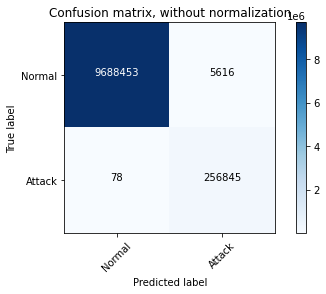

In [69]:
plot_confusion_matrix(confusion_matrix(y_train, clf.predict(x_train)), classes=['Normal', 'Attack'],
                      title='Confusion matrix, without normalization')

In [70]:
print(f"Độ chính xác trên tập train : {accuracy_score(y_test, clf.predict(x_test))}")

Độ chính xác trên tập train : 0.9981902590977249


In [71]:
print(f"Report trên tập train: \n {classification_report(y_test, clf.predict(x_test))}")

Report trên tập train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   4097130
           1       0.94      0.97      0.95     79711

    accuracy                           1.00   4176841
   macro avg       0.97      0.98      0.98   4176841
weighted avg       1.00      1.00      1.00   4176841



In [72]:
print(f"Confusion matrix trên tập train: \n {confusion_matrix(y_test, clf.predict(x_test))}")

Confusion matrix trên tập train: 
 [[4092348    4782]
 [   2777   76934]]


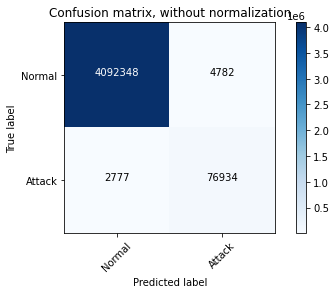

In [73]:
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(x_test)), classes=['Normal', 'Attack'],
                      title='Confusion matrix, without normalization')

In [74]:
print(f"AUC score: \n {roc_auc_score(y_train, clf.predict(x_train))}")
print(f"AUC score: \n {roc_auc_score(y_test, clf.predict(x_test))}")

AUC score: 
 0.9995585418996105
AUC score: 
 0.9819972439867231


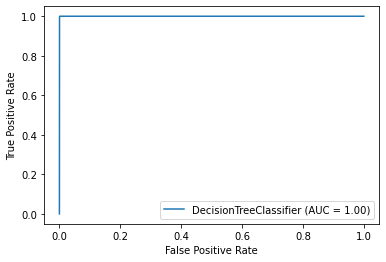

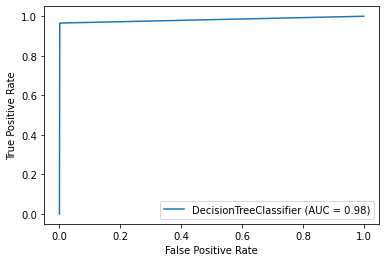

In [75]:
plot_roc_curve(clf, x_train, y_train)
plot_roc_curve(clf, x_test, y_test)

In [76]:
filename = 'ID3_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [77]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.9981902590977249


In [80]:
del loaded_model, clf

# Unsupervised Learning


In [4]:
file_path = './final/'

In [5]:
x_train, y_train, y_train_label = pickle.load(open(file_path+'final_train.pkl', 'rb'))
x_test, y_test, y_test_label = pickle.load(open(file_path+'final_test.pkl', 'rb'))

In [6]:
x_train = x_train[y_train == 0]

In [7]:
x_train.shape

(9694069, 39)

In [11]:
y_train, y_test = map(lambda y: y.apply(convertToOneClass), [y_train, y_test])

In [12]:
y_train.value_counts()

 1    9694069
-1     256923
Name: target, dtype: int64

In [13]:
y_test.value_counts()

 1    4097130
-1      79711
Name: target, dtype: int64

In [ ]:
clf_one = IsolationForest(n_estimators=15, max_samples=700000, n_jobs=4, verbose=1)
clf_one.fit(x_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


In [1]:
import pickle

In [14]:
clf_one = pickle.load(open("one_class.pkl", "rb"))

In [15]:
predY = clf_one.predict(x_test)

In [18]:
score = f1_score(y_test, predY, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.019
